<a href="https://colab.research.google.com/github/luciafrgit/Prueba/blob/main/mu_urbansound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban Sound 8k

In this code, it is trained a convolutional neural network (CNN) model for urban sound classification using the UrbanSound8K dataset.

In [1]:
# Import libraries
import os
import time
import librosa
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
# We download and extract the UrbanSound8K dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2024-06-02 10:56:26--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2024-06-02 10:56:26--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  23.4MB/s    in 3m 24s  

2024-06-02 10:59:50 (28.2 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



Some information about this dataset:

- Dataset Size: Contains 8,732 audio clips.
- Clip Duration: Each clip has a maximum duration of 4 seconds.
- Number of Classes: 10 sound categories.


UrbanSound8K is tagged with 10 categories of urban sounds, which are:

1. Air conditioner
2. Car horn
3. Children playing
4. Dog bark
5. Drilling
6. Engine idling
7. Gun shot
8. Jackhammer
9. Siren
10. Street music

In [3]:
# Functions to work with the data set that are audios

class UrbanSoundDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.root_dir, 'fold'+str(self.annotations.iloc[idx, 5]), self.annotations.iloc[idx, 0])
        audio, sample_rate = librosa.load(audio_path, sr=22050)
        if self.transform:
            audio = self.transform(audio)
        label = torch.tensor(self.annotations.iloc[idx, 6])
        return audio, label


# Feature Extraction and Transformation

def extract_features(audio, sample_rate=22050, n_mfcc=40):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfccs

def pad_features(features, pad_length):
    if features.shape[1] < pad_length:
        pad_width = pad_length - features.shape[1]
        features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
    else:
        features = features[:, :pad_length]
    return features

class MFCCTransform:
    def __init__(self, pad_length):
        self.pad_length = pad_length

    def __call__(self, audio):
        features = extract_features(audio)
        return torch.tensor(pad_features(features, self.pad_length))


In [4]:
# We create the Dataset
csv_file = 'UrbanSound8K/metadata/UrbanSound8K.csv'
root_dir = 'UrbanSound8K/audio'
PAD_LENGTH = 174
transform = MFCCTransform(pad_length=PAD_LENGTH)

dataset = UrbanSoundDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

# We divide it
labels = dataset.annotations['classID']
train_idx, test_idx = train_test_split(list(range(len(labels))), test_size=0.3, random_state=1, stratify=labels)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=1, stratify=[labels[i] for i in test_idx])

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(val_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

# Show the size of each set
print(f'Training set size: {len(train_data)}')
print(f'Validation set size: {len(val_data)}')
print(f'Test set size: {len(test_data)}')


Tamaño del conjunto de entrenamiento: 6112
Tamaño del conjunto de validación: 1310
Tamaño del conjunto de prueba: 1310


In [5]:
# We define the Convolutional Neural Network
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(2, 4))
        self.pool = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(2, 4))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(2, 4))
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(2, 4))
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.global_pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / total
        train_accuracy = correct / total

        val_loss, val_accuracy = evaluate_model_with_loss(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model_with_loss(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss = running_loss / total
    accuracy = correct / total
    return loss, accuracy


In [6]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer)

# Evaluate the model
model.load_state_dict(torch.load('best_model.pth'))
test_accuracy = evaluate_model_with_loss(model, test_loader, criterion)[1]
print(f'Test Accuracy: {test_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Epoch [1/5], Loss: 1.9815, Train Accuracy: 0.2683, Val Accuracy: 0.3916
Epoch [2/5], Loss: 1.5521, Train Accuracy: 0.4545, Val Accuracy: 0.5252
Epoch [3/5], Loss: 1.2955, Train Accuracy: 0.5519, Val Accuracy: 0.6130
Epoch [4/5], Loss: 1.1360, Train Accuracy: 0.6119, Val Accuracy: 0.6000
Epoch [5/5], Loss: 0.9985, Train Accuracy: 0.6628, Val Accuracy: 0.6603
Test Accuracy: 0.6618


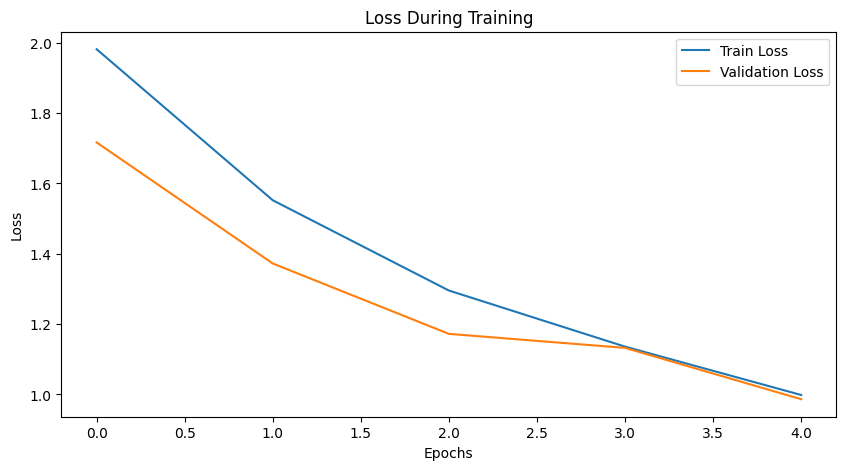

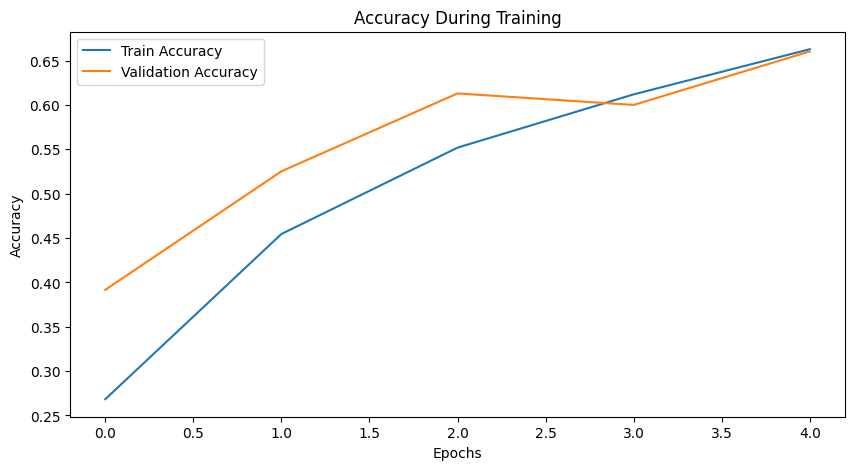

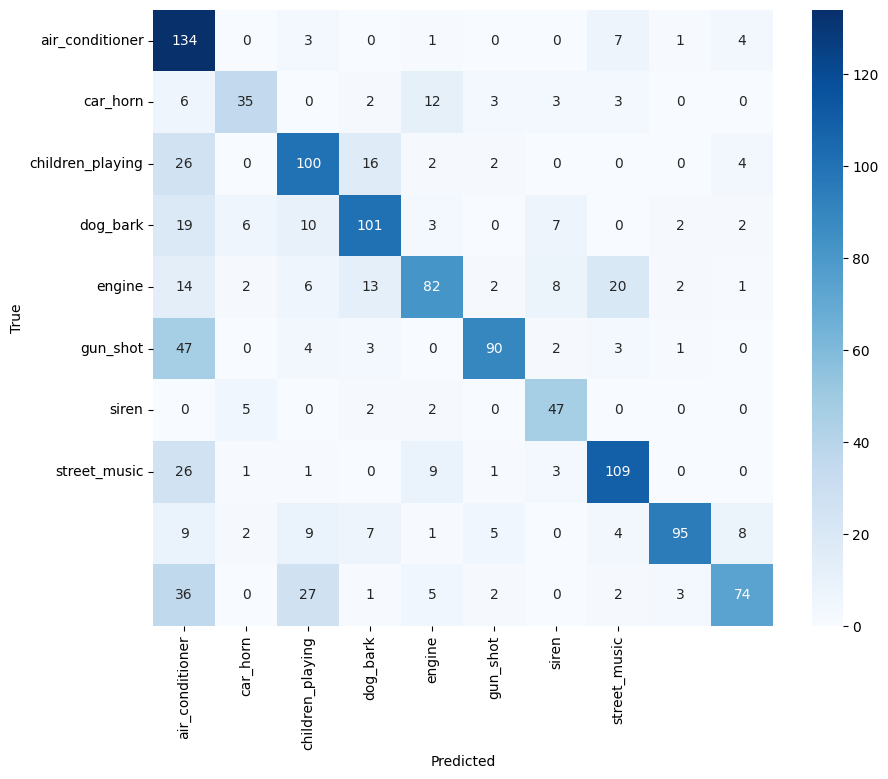

In [7]:
# Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()

# Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training')
plt.legend()
plt.show()

# Confusion Matrix
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.unsqueeze(1))
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

class_dictionary = {3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine'}
classes = [class_dictionary[key] for key in sorted(class_dictionary.keys())]

plot_confusion_matrix(model, test_loader)


# Machine Unlearning
Technique to "unlearn" a specific class (car_horn).

The weights of the model are frozen except those of the class to be unlearned, a new loss function is defined and the model is retrained

In [8]:
# Unlearn 'car_horn' class
class_weights = model.fc.weight.data
class_1_weights = class_weights[1].clone()

# Freeze all weights except those related to class 'car_horn'
for name, param in model.named_parameters():
    if 'fc.weight' in name or 'fc.bias' in name:
        param.requires_grad = False
model.fc.weight.data[1] = class_1_weights.clone()

# Create the optimizer with only the parameters that are not frozen
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Define a new loss function that penalizes the 'car_horn' class
def custom_loss_with_dropout(output, target):
    loss = criterion(output, target)
    penalty = 0.01 * torch.sum((output[:, 1]) ** 2)
    return loss + penalty


In [9]:
# Retrain the model to unlearn the 'car_horn' class
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, custom_loss_with_dropout, optimizer)

# Evaluate the model
model.load_state_dict(torch.load('best_model.pth'))
final_accuracy = evaluate_model_with_loss(model, test_loader, criterion)[1]
print(f'Final Test Accuracy: {final_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Epoch [1/5], Loss: 12.1871, Train Accuracy: 0.4162, Val Accuracy: 0.3160
Epoch [2/5], Loss: 2.0294, Train Accuracy: 0.3753, Val Accuracy: 0.3840
Epoch [3/5], Loss: 1.9149, Train Accuracy: 0.4382, Val Accuracy: 0.4565
Epoch [4/5], Loss: 1.7973, Train Accuracy: 0.4699, Val Accuracy: 0.4565
Epoch [5/5], Loss: 1.6772, Train Accuracy: 0.4843, Val Accuracy: 0.4863
Final Test Accuracy: 0.4962


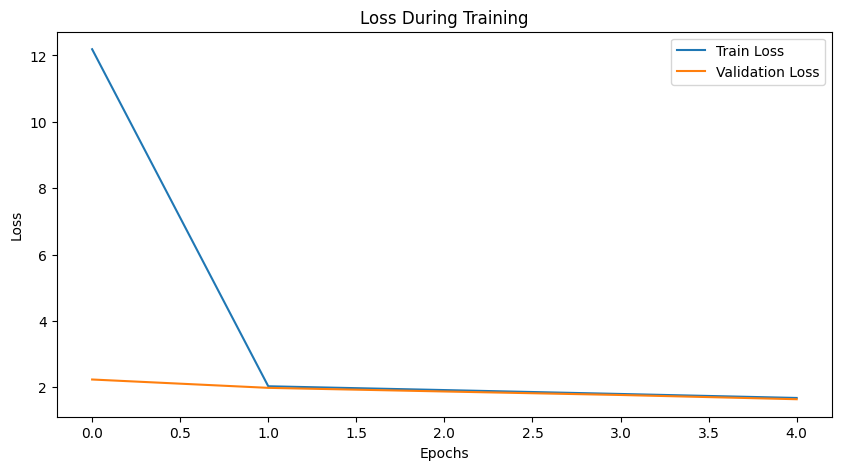

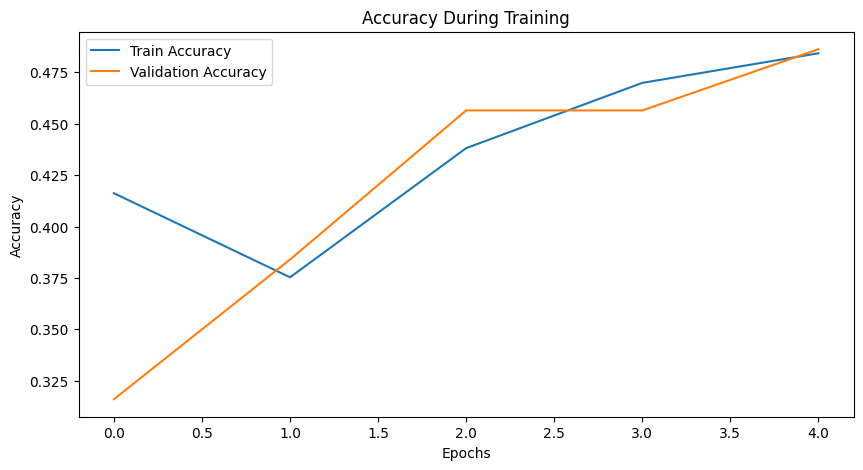

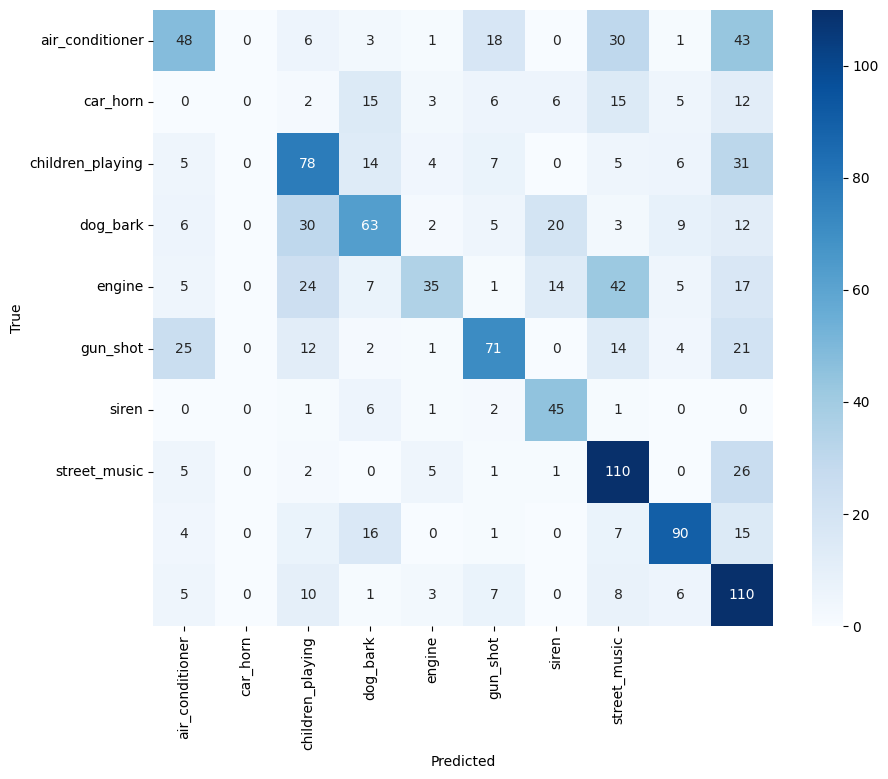

In [10]:
# Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()

# Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training')
plt.legend()
plt.show()

# Confusion Matrix
plot_confusion_matrix(model, test_loader)